# 验证站点数据

# Import packages

In [1]:
# Reading/Writing Data
import os
import glob
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt

# Pytorch
import torch 
from torch.utils.data import DataLoader, random_split

# Self-Defined Package
from SMAPDataset import SMAPDataset
from SMCNN import SMCNN
from Preprocessing import random_spatial_sequence, collate_insitu_validation

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Some Utility Functions

In [3]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 11611801,      # Your seed number, you can pick your lucky number. :)
    'is_train': True,
    'test_batch_size': 1,
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB',
    'model_save_dir': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB\\OUTPUT\\MODELS\\CNN_TRANSFER'
}

In [5]:
# # Set seed for reproducibility
same_seed(config['seed'])

In [6]:
print(config['root'])
# 创建数据集
insitu_dataset = SMAPDataset(config['root'], insitu_validation=True)
# 创建数据加载器
insitu_loader = DataLoader(insitu_dataset, batch_size=config['test_batch_size'], shuffle=False, collate_fn=collate_insitu_validation)

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB
***************************Load data path******************************
_______________________________2015104_______________________________
_____________________________smap cell: 15_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015104\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015104\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015104\4.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015104\4.npy
_____________________________smap cell: 17_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015104\17.npy
D:\1GRADUATED\paper\downscali

_____________________________smap cell: 9_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015202\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015202\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015202\55.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015202\55.npy
_______________________________2015203_______________________________
_____________________________smap cell: 16_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015203\16.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\16.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015283\53.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015283\53.npy
_____________________________smap cell: 44_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015283\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015283\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015283\11.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015283\11.npy
_____________________________smap cell: 51_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015283\51.npy
D:\1GRADUATED\paper\downscaling_data\

In [7]:
print(len(insitu_dataset))

493


In [8]:
import datetime

# The index of day start from 1
# day 从 1 开始
def date2day(date, fm="%Y-%m-%d"):
    date_object = datetime.datetime.strptime(date, fm)
    day_of_year = date_object.timetuple().tm_yday
    return day_of_year

def day2date(year, day):
    date = datetime.datetime(year, 1, 1) + datetime.timedelta(day - 1)
    month = date.month
    day = date.day
    return date

In [9]:
def tester(test_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
#     criterion = ab_physics_loss
    model.eval()
    pred_pkg = {'date':[], 'smapid':[], 'insituid':[], 'a': [], 'b': [], 'smap': [], 'insitu_ati': [], 'insitu_sm':[], 'pred_sm':[]}
    pred_list = np.zeros((len(test_loader), 2))
    for i, data_pkg in enumerate(test_loader):
        x = data_pkg['processed_data']
        with torch.no_grad():
            pred = model(x)
            relu(pred[:, 0])
#             x, pred = x.to(device), pred.to(device)  
        year = 2015
        day = int(data_pkg['meta_data'][0]['date'].split(str(year))[-1])
        date = day2date(year, day)
        smapid = data_pkg['meta_data'][0]['smapid']
        insituid_list = data_pkg['meta_data'][0]['insituid']
        for i in range(len(insituid_list)):
            # 去点站点sm为零的数据
            if(data_pkg['label_data']['insitu_sm'][0][i][0]<=0):
                continue
            if(insituid_list[i]=='16' or insituid_list[i]=='33'):
                continue
            pred_pkg['date'].append(date)
            pred_pkg['smapid'].append(smapid)
            pred_pkg['insituid'].append(insituid_list[i])
            pred_pkg['a'].append(pred[0][0].item())
            pred_pkg['b'].append(pred[0][1].item())
            pred_pkg['smap'].append(data_pkg['label_data']['smap'][0][0].detach().item())
            pred_pkg['insitu_ati'].append(data_pkg['label_data']['insitu_ati'][0][i][0])
            pred_pkg['insitu_sm'].append(data_pkg['label_data']['insitu_sm'][0][i][0])
            pred_sm = pred[0][0].item()*data_pkg['label_data']['insitu_ati'][0][i][0] + pred[0][1].item()
            pred_pkg['pred_sm'].append(pred_sm)
            
    return pred_pkg

In [10]:
param_path = os.path.join(config['model_save_dir'], 'first.ckpt' )
print(insitu_dataset.get_input_shape(0))
model = SMCNN(input_channel=insitu_dataset.get_input_shape(0)[2]).to(device)
print(model)
model.load_state_dict(torch.load(param_path))
pred_pkg = tester(insitu_loader, model, config, device) 

(11, 11, 19)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(19, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


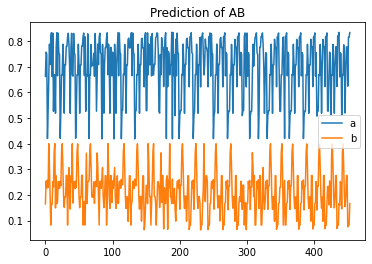

In [11]:
plt.plot(pred_pkg['a'], label='a')
plt.plot(pred_pkg['b'], label='b')
# 添加标题和标签
plt.title('Prediction of AB')
# plt.xlabel('Index of Model')
plt.legend()
plt.show()

In [12]:
df = pd.DataFrame(pred_pkg)
df = df.sort_values(by='date', ascending=True, kind='stable')
df = df.sort_values(by='insituid', ascending=True, kind='stable')
df = df.reset_index(drop=True)
print(df)
df.info()

          date smapid insituid         a         b      smap  insitu_ati  \
0   2015-04-16     16        1  0.831226  0.251612  0.204734    0.036178   
1   2015-04-25     16        1  0.831115  0.251556  0.194087    0.046995   
2   2015-04-27     16        1  0.830665  0.251329  0.196959    0.074818   
3   2015-05-10     16        1  0.830559  0.251268  0.188260    0.060765   
4   2015-05-11     16        1  0.830110  0.251014  0.188378    0.041569   
..         ...    ...      ...       ...       ...       ...         ...   
449 2015-09-15     41        6  0.807072  0.097777  0.264639    0.059580   
450 2015-10-09     41        6  0.807331  0.097959  0.232548    0.044548   
451 2015-10-15     41        6  0.806799  0.097595  0.205021    0.042050   
452 2015-10-17     41        6  0.807310  0.097945  0.206502    0.047355   
453 2015-10-18     41        6  0.806534  0.097422  0.192326    0.035588   

     insitu_sm   pred_sm  
0     0.414997  0.281684  
1     0.434795  0.290614  
2     

In [13]:
import random

start = 0
end = df.shape[0]-1
num_samples = 1

sample = np.random.randint(start, end+1, size=num_samples)
print(sample)

[107]


In [14]:
df.iloc[sample]

,date,smapid,insituid,a,b,smap,insitu_ati,insitu_sm,pred_sm
107,2015-04-25,2,2,0.421236,0.254353,0.143473,0.052962,0.497475,0.276662


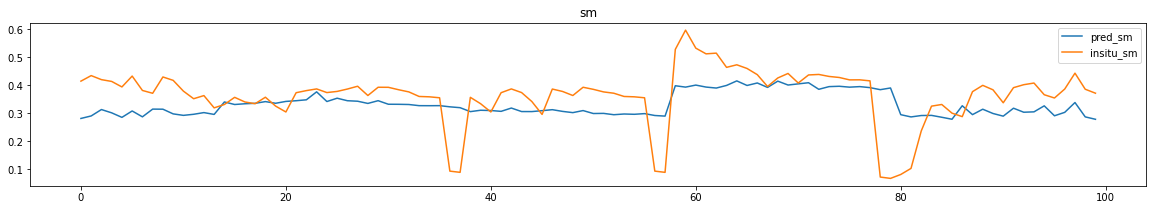

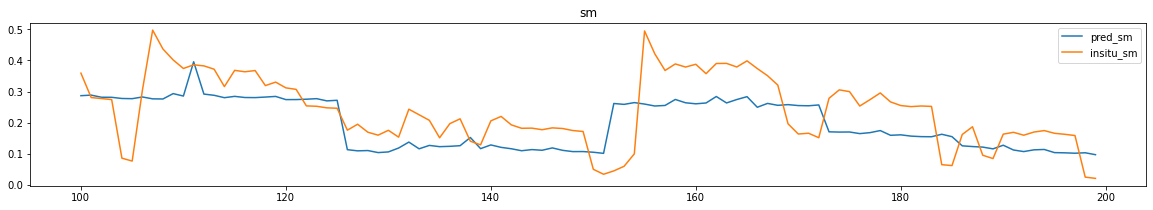

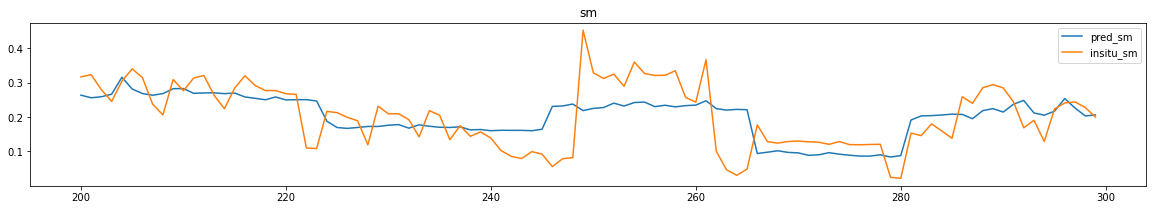

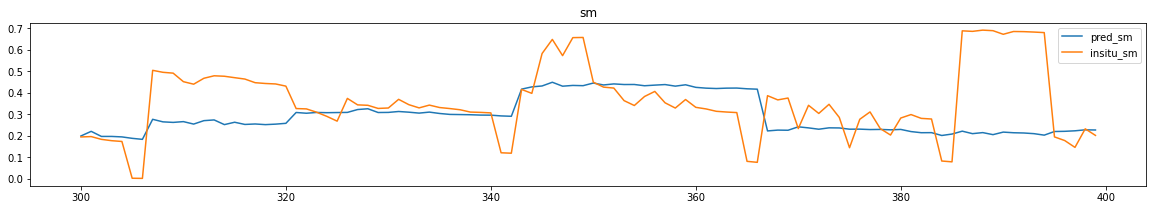

In [15]:
for i in range(4):
    plt.figure(figsize=(20,3))
    plt.plot(df['pred_sm'].iloc[i*100:(i+1)*100], label='pred_sm')
    plt.plot(df['insitu_sm'].iloc[i*100:(i+1)*100], label='insitu_sm')
    # 添加标题和标签
    plt.title('sm')
    plt.legend()
    plt.savefig(os.path.join(config['model_save_dir'], 'sm for all waternet part '+str(i)), dpi=300, bbox_inches='tight')
    plt.show()

# 总体R和RMSE

In [16]:
corr = df['pred_sm'].corr(df['insitu_sm'])
print(corr)

0.576598590182455


In [17]:
from sklearn.metrics import mean_squared_error
# calculate the mean squared error (MSE)
mse = mean_squared_error(df['insitu_sm'], df['pred_sm'])

# calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print(rmse)

0.1157249838528849


# 站点R和RMSE

In [18]:
print(df['insituid'])

0      1
1      1
2      1
3      1
4      1
      ..
449    6
450    6
451    6
452    6
453    6
Name: insituid, Length: 454, dtype: object


In [19]:
insitu_grouped = df.groupby(['insituid'])

In [20]:
def calc_rmse(group):
    return np.sqrt(mean_squared_error(group['insitu_sm'], group['pred_sm']))

def calc_corr(group):
    return group.corr().iloc[0, 1]

In [21]:
insitu_rmse = insitu_grouped.apply(calc_rmse)
print(insitu_rmse)

insituid
1     0.101607
10    0.073992
11    0.086543
12    0.122303
18    0.100231
2     0.083907
22    0.070383
25    0.132897
27    0.106441
30    0.055925
31    0.054611
32    0.045038
35    0.129641
37    0.042686
4     0.066270
40    0.204295
42    0.058711
5     0.145648
52    0.093268
53    0.472372
54    0.066105
55    0.045805
6     0.120573
dtype: float64


(14, 9)
0.10160692457235569


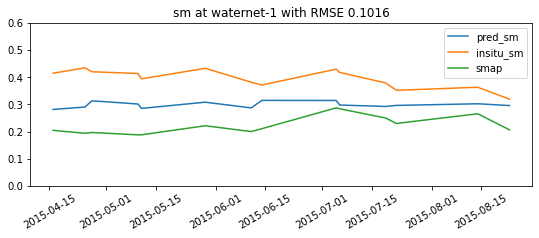

(24, 9)
0.0739920992781483


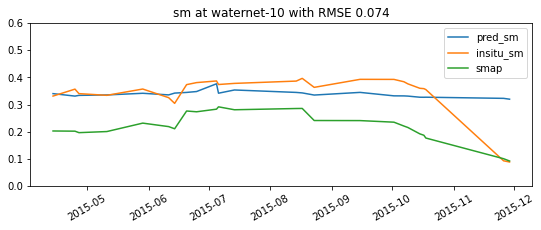

(20, 9)
0.08654287781992584


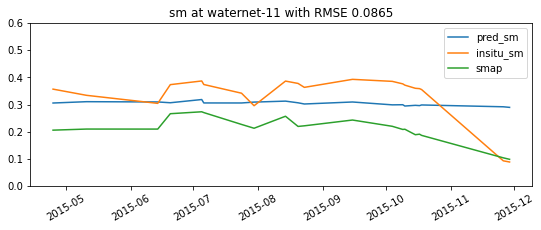

(22, 9)
0.1223029385828707


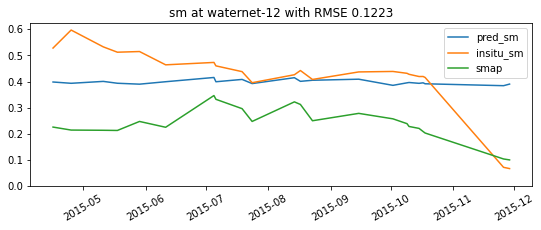

(26, 9)
0.10023143506684293


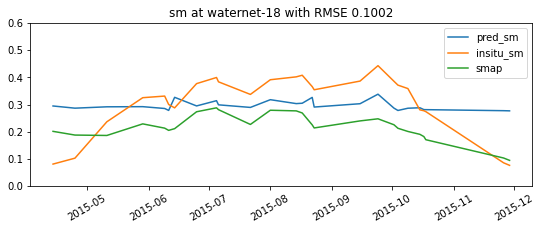

(20, 9)
0.0839069508121519


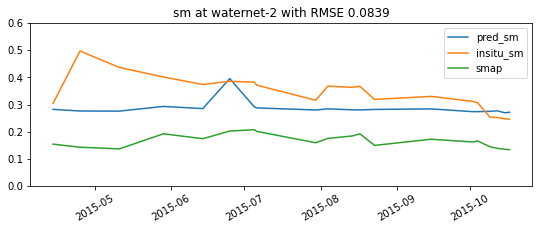

(26, 9)
0.07038332064487848


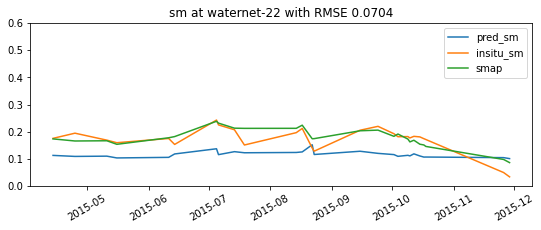

(21, 9)
0.13289729973159917


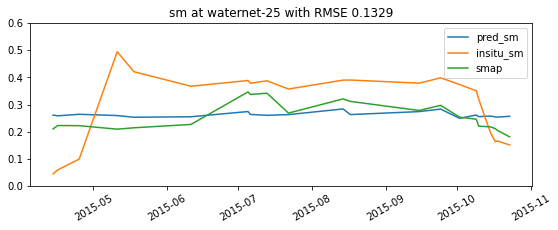

(13, 9)
0.10644073141804457


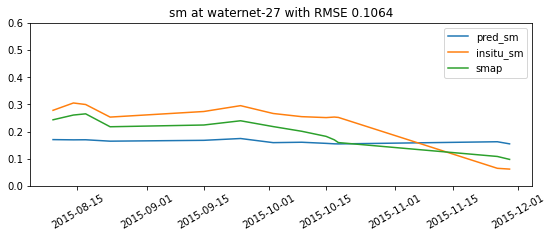

(14, 9)
0.055925282653173154


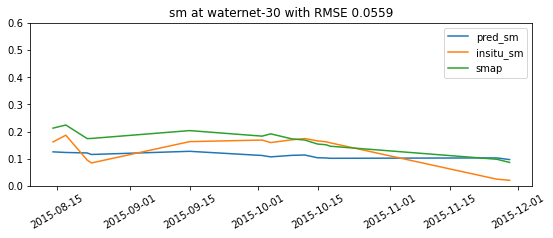

(24, 9)
0.05461146667225078


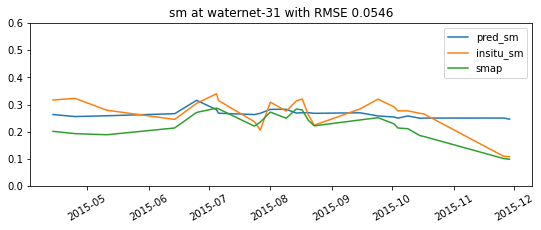

(22, 9)
0.04503806174164802


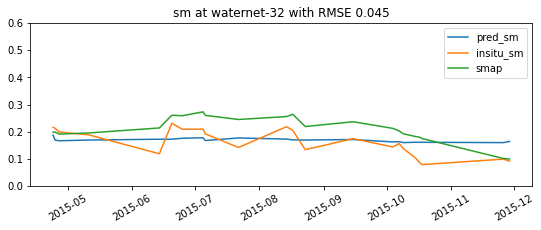

(20, 9)
0.12964057511291202


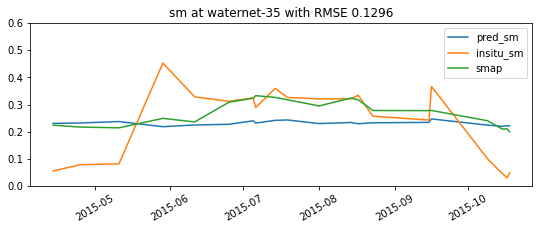

(15, 9)
0.042686481453686025


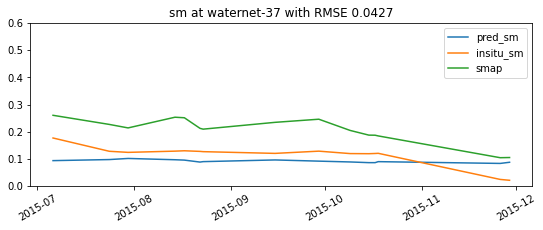

(26, 9)
0.0662703827770305


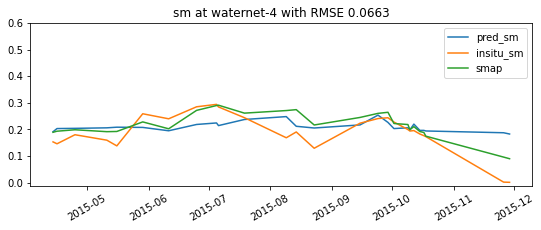

(14, 9)
0.20429536794423755


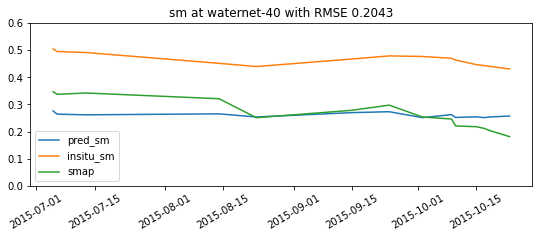

(22, 9)
0.05871119584912563


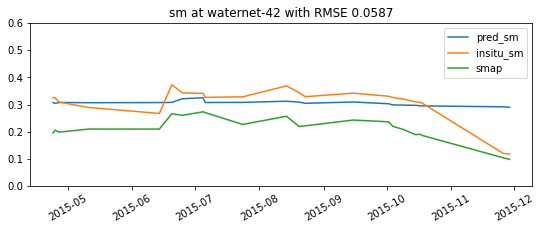

(24, 9)
0.14564764781323264


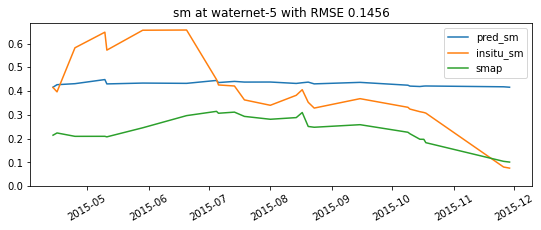

(19, 9)
0.09326808669044905


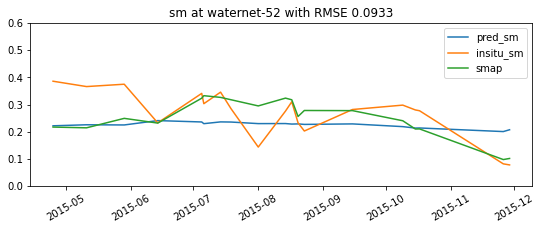

(9, 9)
0.47237231881614816


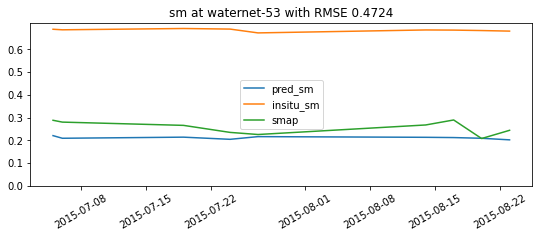

(21, 9)
0.06610535689890669


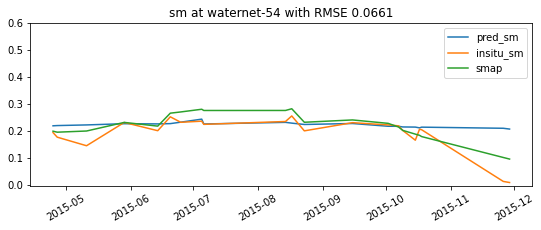

(28, 9)
0.04580464545154618


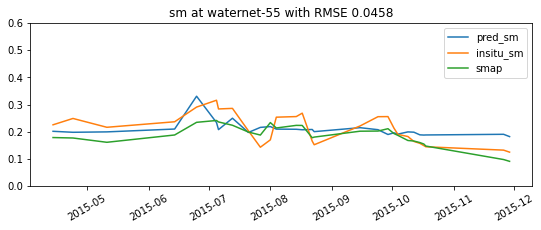

(10, 9)
0.1205727830914663


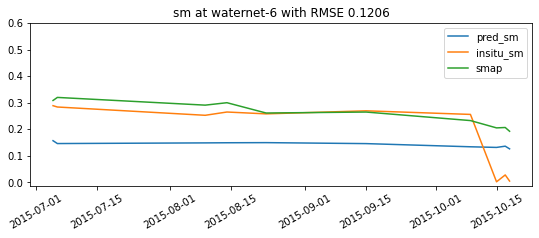

In [26]:
i = 0
for name, group in insitu_grouped:
    print(group.shape)
    print(insitu_rmse.iloc[i])
    plt.figure(figsize=(9,3))
    plt.plot(group['date'], group['pred_sm'], label='pred_sm')
    plt.plot(group['date'], group['insitu_sm'], label='insitu_sm')
    plt.plot(group['date'], group['smap'], label='smap')
    # 添加标题和标签
    plt.title('sm at waternet-'+ name + ' with RMSE ' + str(np.round(insitu_rmse.iloc[i], 4)))
    plt.legend()
    plt.xticks(rotation=30)
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
    plt.savefig(os.path.join(config['model_save_dir'], 'sm at waternet-'+ name + 'with RMSE ' + str(np.round(insitu_rmse.iloc[i], 4)) + '.png'), dpi=300, bbox_inches='tight')
    plt.show()
    i+=1

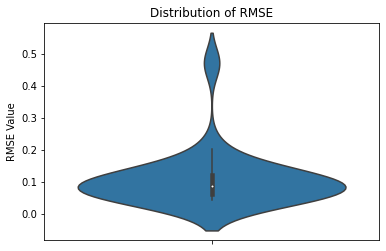

In [23]:
# 将数据转换为DataFrame格式
df_rmse = pd.DataFrame(insitu_rmse, columns=['RMSE'])

# 绘制小提琴图
sns.violinplot(y='RMSE', data=df_rmse, scale='count')
# sns.barplot(y='MSE', data=df)
# 添加标题和标签
plt.title('Distribution of RMSE')
# plt.xlabel('Index of Model')
plt.ylabel('RMSE Value')

# 显示图形
# plt.savefig(config['root'] + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\CNN\\' + str(config['seed']) + '\\' + 'MSEDistribution.png', dpi=600, transparent=False)    
plt.show()

In [24]:
insitu_corr = insitu_grouped[['pred_sm', 'insitu_sm']].apply(calc_corr)
print(insitu_corr)

insituid
1     0.146019
10    0.494654
11    0.536404
12    0.326654
18    0.485526
2     0.257983
22    0.378161
25    0.281765
27    0.462391
30    0.385630
31    0.393065
32    0.660735
35    0.363688
37    0.503109
4     0.540692
40    0.623111
42    0.621955
5     0.571178
52    0.476399
53    0.020422
54    0.655072
55    0.533826
6     0.815141
dtype: float64


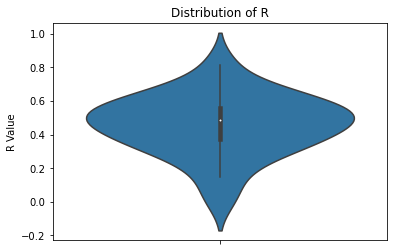

In [25]:
# 将数据转换为DataFrame格式
df_corr = pd.DataFrame(insitu_corr, columns=['R'])

# 绘制小提琴图
sns.violinplot(y='R', data=df_corr, scale='count')
# sns.barplot(y='MSE', data=df)
# 添加标题和标签
plt.title('Distribution of R')
# plt.xlabel('Index of Model')
plt.ylabel('R Value')

# 显示图形
# plt.savefig(config['root'] + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\CNN\\' + str(config['seed']) + '\\' + 'MSEDistribution.png', dpi=600, transparent=False)    
plt.show()